<a href="https://colab.research.google.com/github/Rohit-Prasanna/BrainTumor_detection_ResNet50/blob/main/BrainTumor_Detection_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!pip install kaggle


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 145M/149M [00:00<00:00, 213MB/s]
100% 149M/149M [00:00<00:00, 198MB/s]


In [5]:
from zipfile import ZipFile
file_name = "brain-tumor-mri-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [6]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)
for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [8]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [9]:
X_train.shape


(7023, 224, 224, 3)

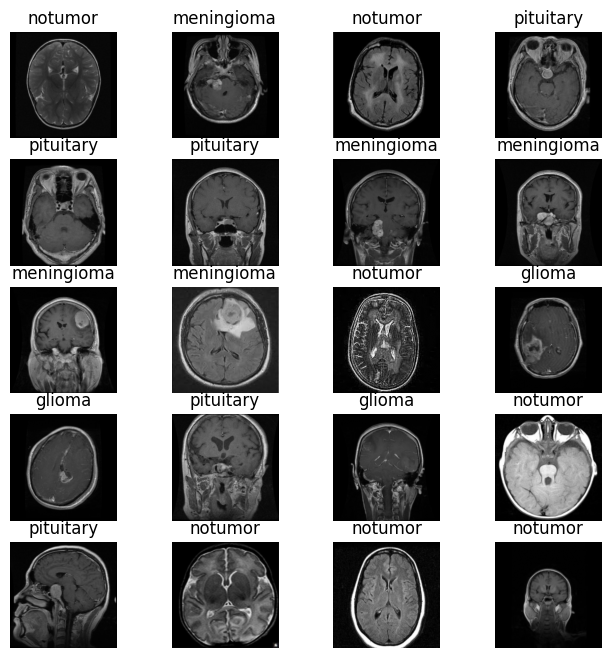

In [10]:
#plotting the images
plt.figure(figsize=(8,8))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [13]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# convert string to categorical
y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)

In [14]:
from keras.applications import ResNet50

# Load ResNet50 model with pre-trained weights
base_model = ResNet50(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Unfreeze some layers in the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('Bmodel.h5', monitor='val_loss', save_best_only=True)

# Model summary
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 51

In [15]:
history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32),
                    epochs=50,  # Increase the number of epochs as needed
                    validation_data=(X_valid, y_valid_new),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50
158/158 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.7083

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 342s 2s/step - loss: 0.7487 - accuracy: 0.7083 - val_loss: 1.4921 - val_accuracy: 0.3096
Epoch 2/50
158/158 [==============================] - 319s 2s/step - loss: 0.3672 - accuracy: 0.8687 - val_loss: 1.4058 - val_accuracy: 0.4021
Epoch 3/50
158/158 [==============================] - 320s 2s/step - loss: 0.2459 - accuracy: 0.9110 - val_loss: 1.1626 - val_accuracy: 0.4395
Epoch 4/50
158/158 [==============================] - 325s 2s/step - loss: 0.1906 - accuracy: 0.9343 - val_loss: 0.7886 - val_accuracy: 0.6512
Epoch 5/50
158/158 [==============================] - 324s 2s/step - loss: 0.1383 - accuracy: 0.9521 - val_loss: 0.6755 - val_accuracy: 0.7046
Epoch 6/50
158/158 [==============================] - 321s 2s/step - loss: 0.1132 - accuracy: 0.9636 - val_loss: 0.5911 - val_accuracy: 0.7900
Epoch 7/50
158/158 [==============================] - 322s 2s/step - loss: 0.1152 - accuracy: 0.9644 - val_loss: 0.2626 - val_accuracy: 0.9039
Epoch 8/50

In [17]:
model = load_model('Bmodel.h5')


44/44 [==============================] - 24s 530ms/step - loss: 0.0550 - accuracy: 0.9829


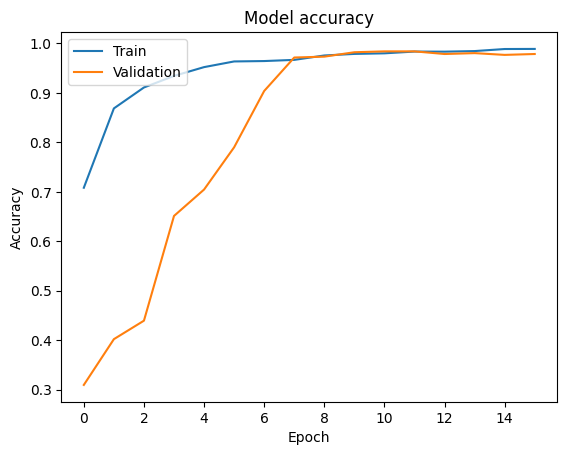

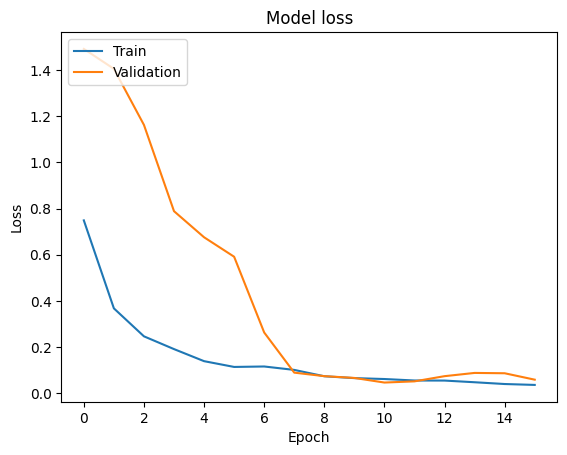

In [18]:
model.evaluate(X_test, y_test_new)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

44/44 [==============================] - 23s 500ms/step


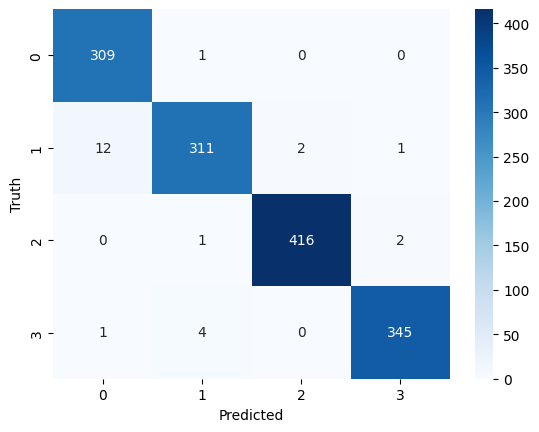

In [19]:
# Predict the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.96      1.00      0.98       310
  meningioma       0.98      0.95      0.97       326
     notumor       1.00      0.99      0.99       419
   pituitary       0.99      0.99      0.99       350

    accuracy                           0.98      1405
   macro avg       0.98      0.98      0.98      1405
weighted avg       0.98      0.98      0.98      1405



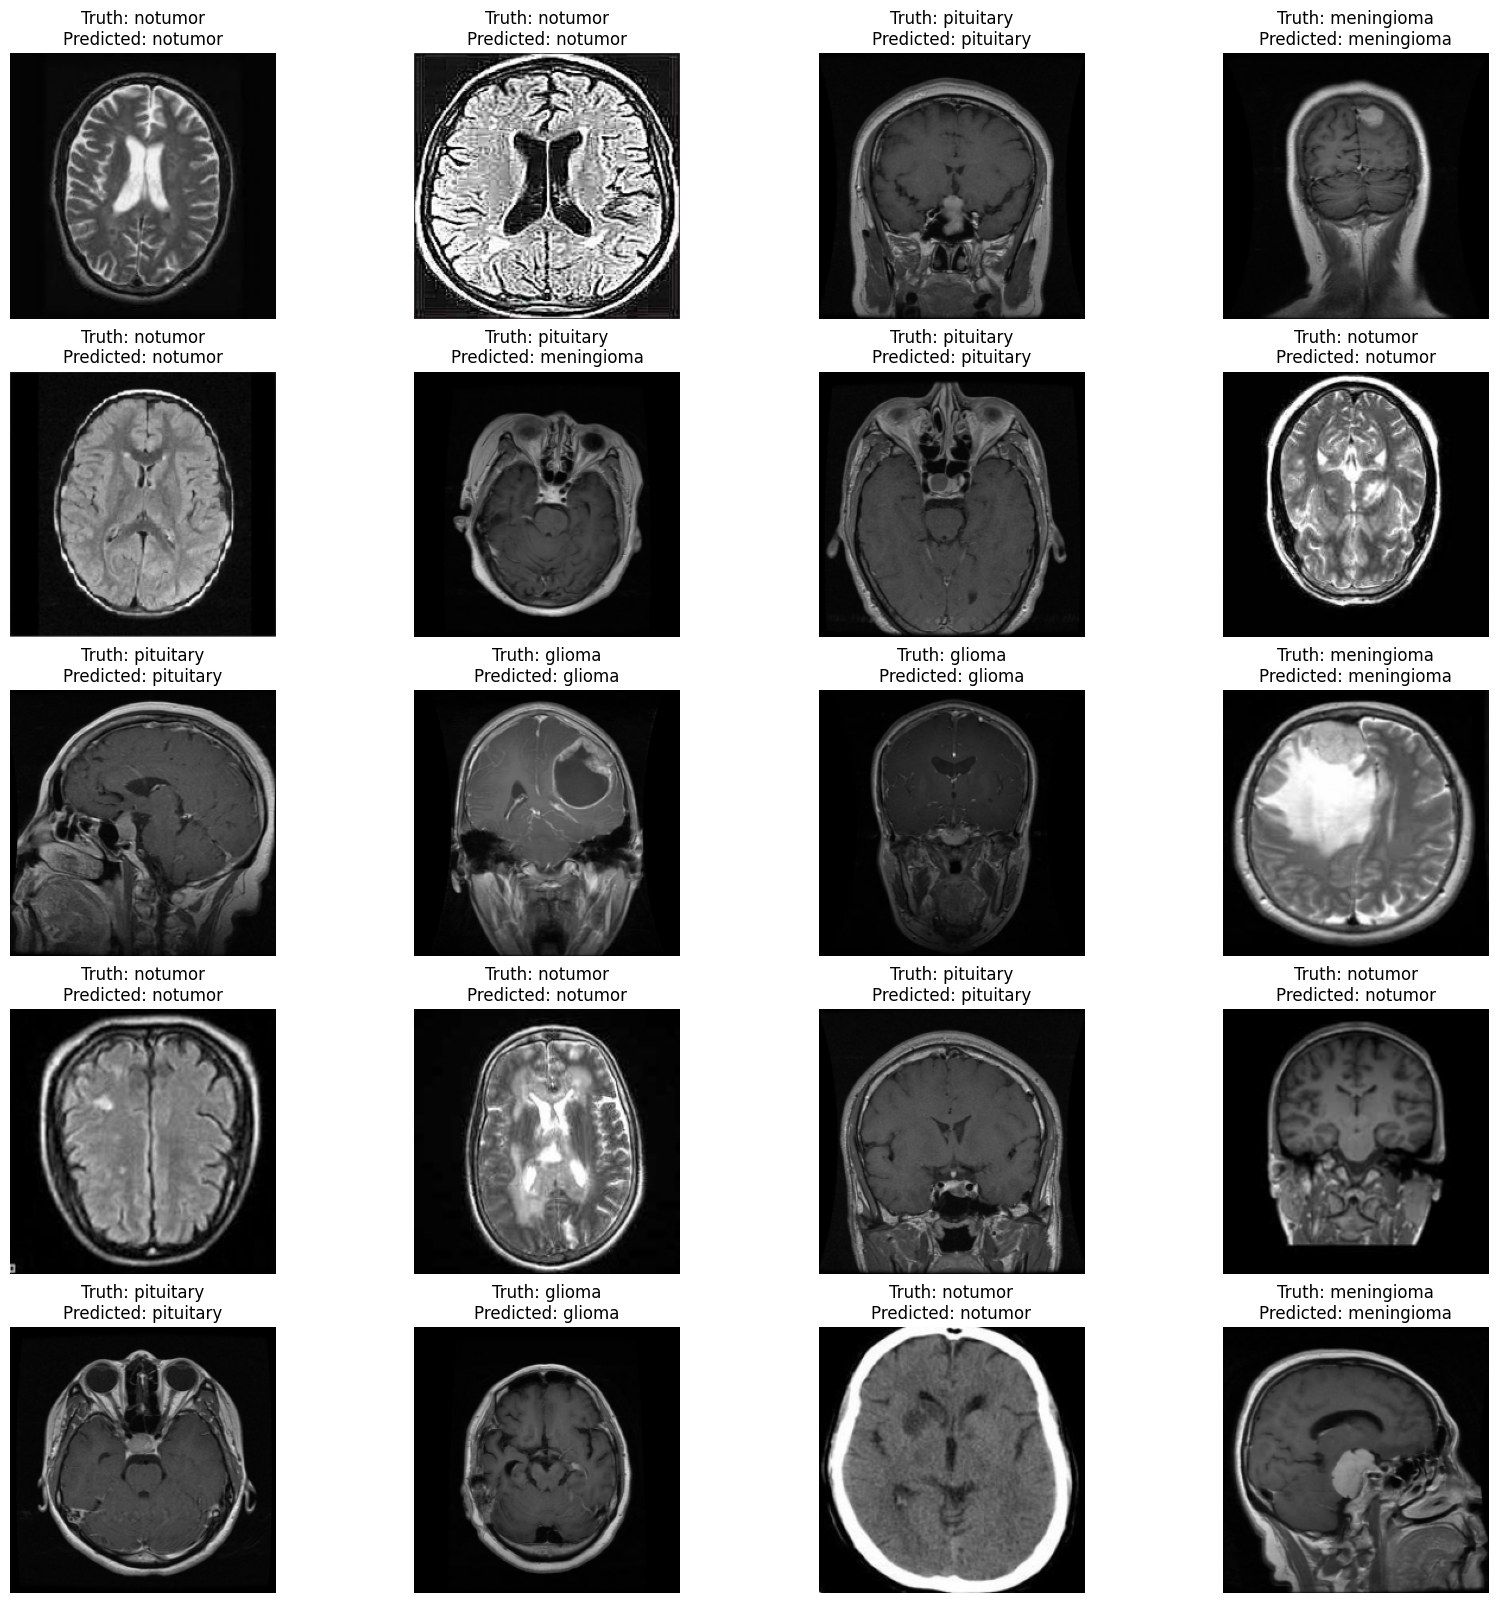

In [21]:
# Visualizing Model Predictions
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred[i]]}")
    plt.axis('off')
plt.show()